# Simulating interconnections of systems 
Sawyer B. Fuller 2023.03

This example creates a precise simulation of a sampled-data control system consisting of discrete-time controller(s) and continuous-time plant dynamics like the following.
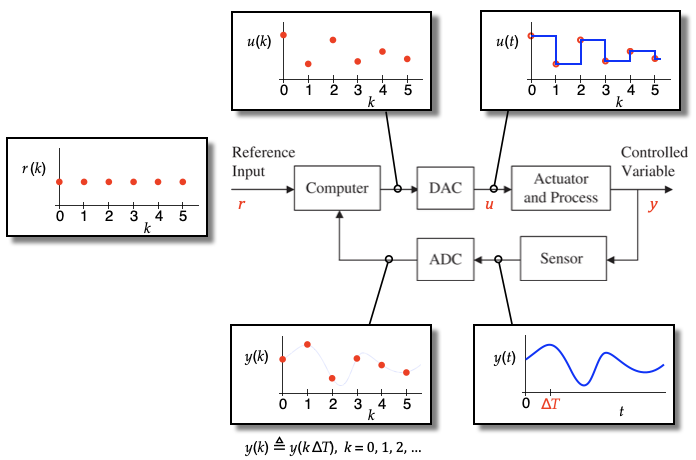

In many cases, it is sufficient to use a discretized model of your plant using a zero-order-hold for control design because it is exact at the sampling instants. However, a more complete simulation of your sampled-data feedback control system may be desired if you want to additionally 

* observe behavior that occurs between sampling instants,
* model the effect of time delays,
* simulate your controller operating with a nonlinear plant, which may not have an exact zero-order-hold discretization

Here, we include helper functions that can be used in conjunction with the Python Control Systems Library to create a simulation of such a closed-loop system, providing a Simulink-like interconnection system. 

Our approach is to discretize all of the constituent systems, including the plant and controller(s) with a much shorter time step `simulation_dt` that we specify. With this, behavior that occurs between the sampling instants of our discrete-time controller can be observed. 

In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
%config InlineBackend.figure_format='retina' # high-res plots

import control as ct # control systems library

We will assume the controller is a discrete-time system of the form

$x[k+1] = f(x[k], u[k])$<br> $~~~~~~~y[k]=g(x[k],u[k])$ 

For this course we will primarily work with linear systems of the form 

$x[k+1] = Ax[k]+Bu[k]$<br> $~~~~~~~y[k]=Cx[k]+Du[k]$   

The plant is assumed to be continuous-time, of the form 

$\dot x = f(x(t), u(t))$, <br>$y = g(x(t), u(t))$

For this course, we will design our controller using a linearized model of the plant given by  

$\dot x = Ax + Bu$, <br>$y = Cx + Du$ 

The first step to create our interconnected system is to create a discrete-time model of the plant, which uses the short time interval `simulation_dt`. Each subsystem gets signal names according to the diagram above, and we use `interconnect` to automatically connect signals of the same name. 

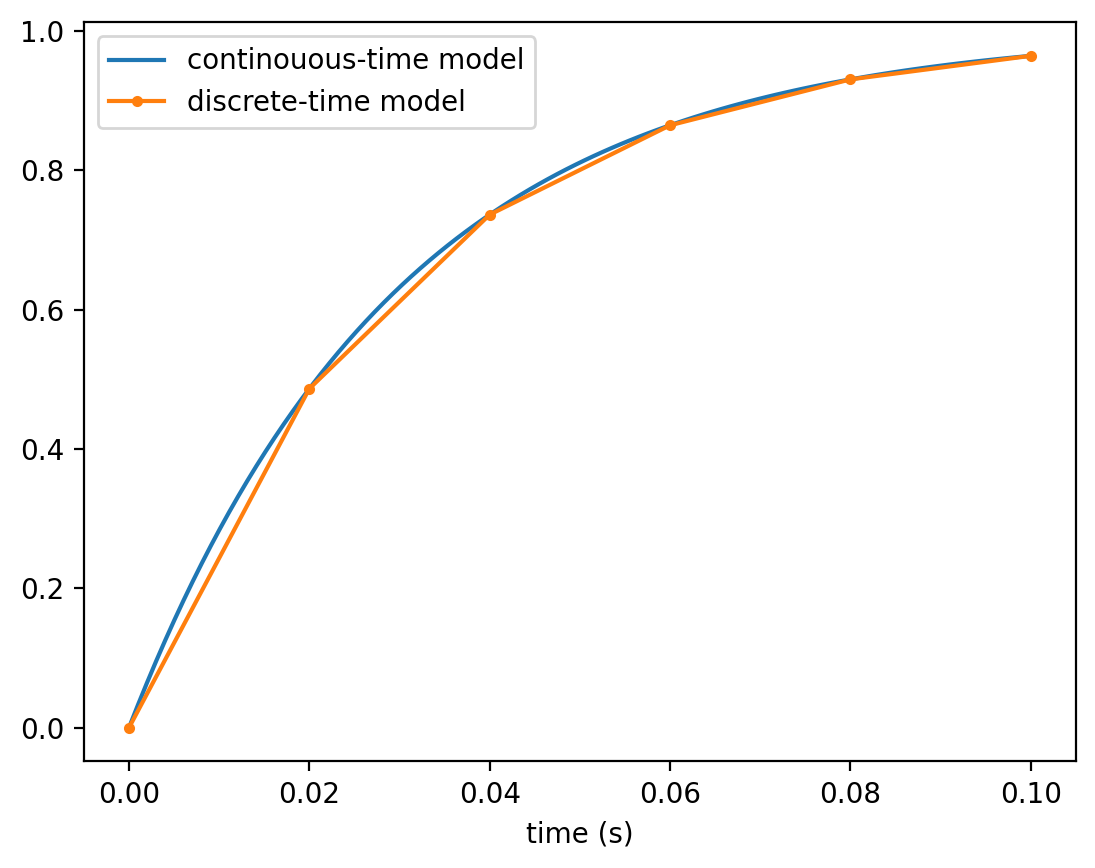

In [2]:
# continuous-time plant model
plantcont = ct.tf(1, (0.03, 1), inputs='u', outputs='y')
t, y = ct.step_response(plantcont, 0.1)
plt.plot(t, y, label='continouous-time model')

# create discrete-time simulation form assuming a zero-order hold
simulation_dt = 0.02 # time step for numerical simulation ("numerical integration")
plant_simulator = ct.c2d(plantcont, simulation_dt, 'zoh')

t, y = ct.step_response(plant_simulator, 0.1)
plt.plot(t, y, '.-', label='discrete-time model')
plt.legend()
plt.xlabel('time (s)');

Next we create a model of a sampled-data controller that operates as a nonlinear discrete-time system with a much shorter time step than the controller's sampling time `Ts`. 

In [3]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a (discrete-time, non-linear) system that models the behavior 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, consisting of a sampler and a digital-to-analog converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    approximation with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    assert ct.isdtime(controller, True), "controller must be discrete-time"
    controller = ct.ss(controller) # convert to state-space if not already
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    def updatefunction(t, x, u, params): # update if it is time to sample 
        nonlocal step
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0
        return x
    y = np.zeros((controller.noutputs, 1))
    def outputfunction(t, x, u, params): # update if it is time to sample
        nonlocal y
        if step == 0: # last time updatefunction was called was a sample time
            y = controller._out(t, x, u) 
        return y
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [4]:
# create discrete-time controller with some dynamics
controller_Ts = .1 # sampling interval of controller
controller = ct.tf(1, [1, -.9], controller_Ts, inputs='e', outputs='u')

# create model of controller with a much shorter sampling time for simulation
controller_simulator = sampled_data_controller(controller, simulation_dt)

If the model is simulated with a short time step, its staircase output behavior can be observed. Because the controller model is nonlinear, we must use `ct.input_output_response`.

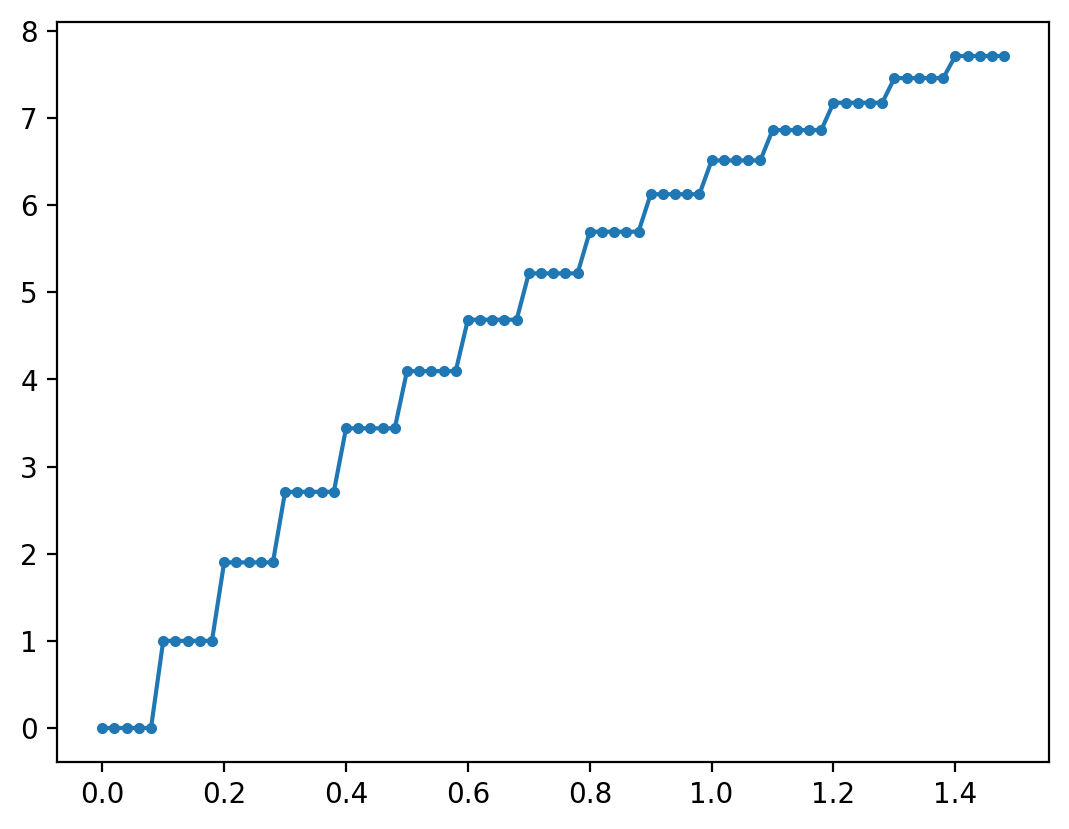

In [5]:
time = np.arange(0, 1.5, simulation_dt)
step_input = np.ones_like(time)
t, y = ct.input_output_response(controller_simulator, time, step_input)
plt.plot(t, y, '.-');

## simulating a closed-loop system

Now we are able to construct a closed-loop simulation of the full sampled-data system. 

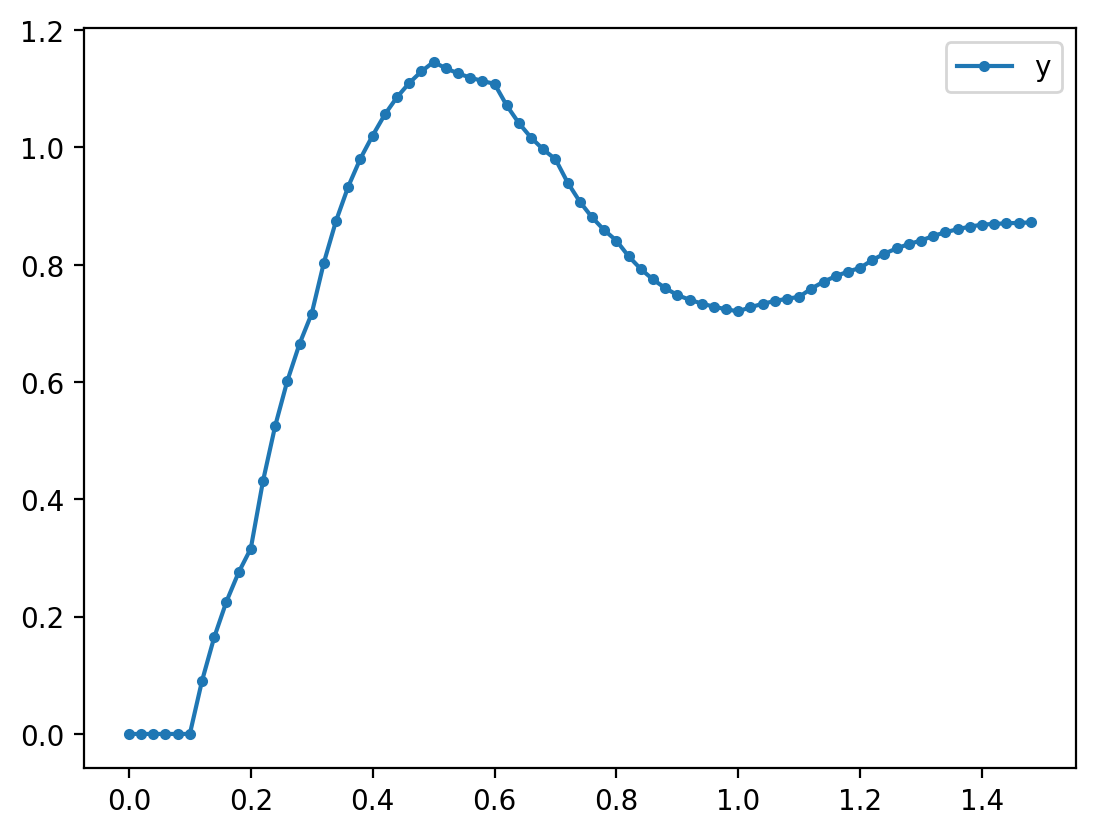

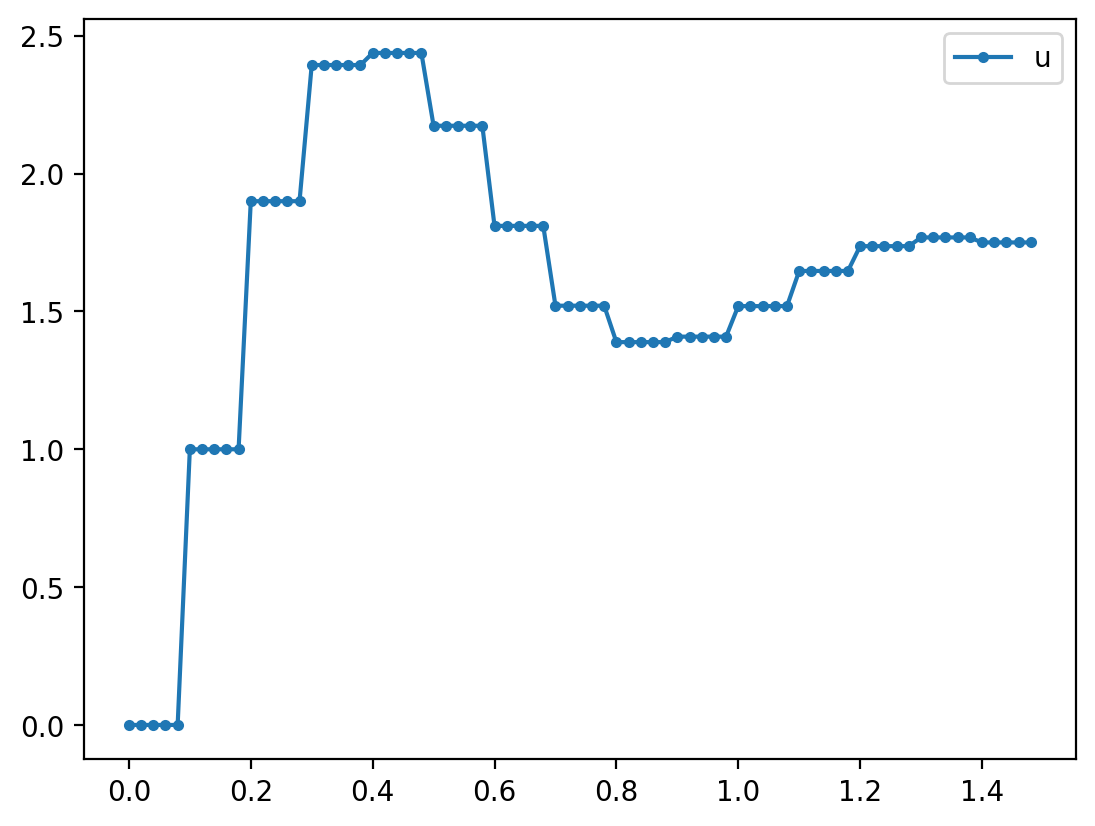

In [6]:
plantcont = ct.tf(.5, (0.1, 1), inputs='u', outputs='y')
u_summer  = ct.summing_junction(inputs=['-y', 'r'], outputs='e')

plant_simulator = ct.c2d(plantcont, simulation_dt, 'zoh')
# system from r to y
Gyr_simulator = ct.interconnect([controller_simulator, plant_simulator, u_summer], 
    inputs='r', outputs=['y', 'u'])

# simulate
t, y = ct.input_output_response(Gyr_simulator, time, step_input)
y, u = y # extract respones
plt.plot(t, y, '.-', label='y')
plt.legend()
plt.figure()
plt.plot(t, u, '.-', label='u')
plt.legend();

## time delays

Given that all of the interconnected systems are being simulated in discrete-time with the same small time interval `simulation_dt`, we can construct a system that implements time delays by suitable choice of $A, B, C, $ and $D$ matrices. For example, a 3-step delay has the form 

$x[k+1] = \begin{bmatrix}0 & 0 & 0\\ 1 & 0 & 0\\ 0 & 1 & 0\end{bmatrix}x[k]+\begin{bmatrix}1\\0\\0\end{bmatrix}u[k]$<br> 

$~~~~~~~y[k]=\begin{bmatrix}0 & 0 & 1\end{bmatrix}x[k]$  

The following function creates an arbitrarily-long time delay system, up to the nearest $dt$. 

In [7]:
def time_delay_system(delay, dt, inputs=1, outputs=1, **kwargs):
    """
    creates a pure time delay discrete-time system. 
    time delay is equal to nearest whole number of `dt`s."""
    assert delay >= 0, "delay must be greater than or equal to zero"
    n = int(round(delay/dt))
    ninputs = inputs if isinstance(inputs, (int, float)) else len(inputs)
    assert ninputs == 1, "only one input supported"
    A = np.eye(n, k=-1)
    B = np.eye(n, 1)
    C = np.eye(1, n, k=n-1)
    D = np.zeros((1,1))
    return ct.ss(A, B, C, D, dt, inputs=inputs, outputs=outputs, **kwargs)

The step response of the time-delay system is shifted to the right.

StateSpace(array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]]), array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]]), array([[0., 0., 0., 0., 1.]]), array([[0.]]), 0.02)

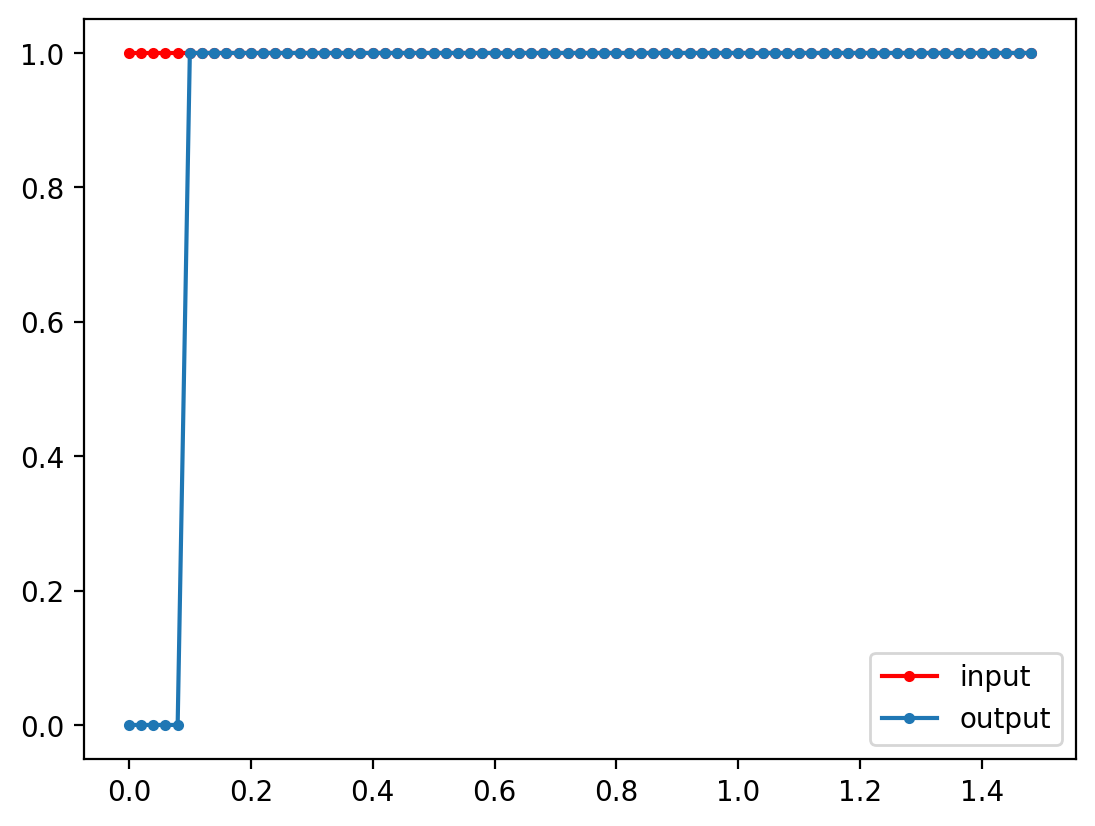

In [8]:
delayer = time_delay_system(.1, simulation_dt, inputs='u', outputs='ud')
t, y  = ct.input_output_response(delayer, time, step_input) 
plt.plot(time, step_input, 'r.-', label='input')
plt.plot(t, y, '.-', label='output')
plt.legend()
delayer

We can incorporate this delay into our closed-loop system. The time delay shifts the response to the right and brings the system closer to instability.

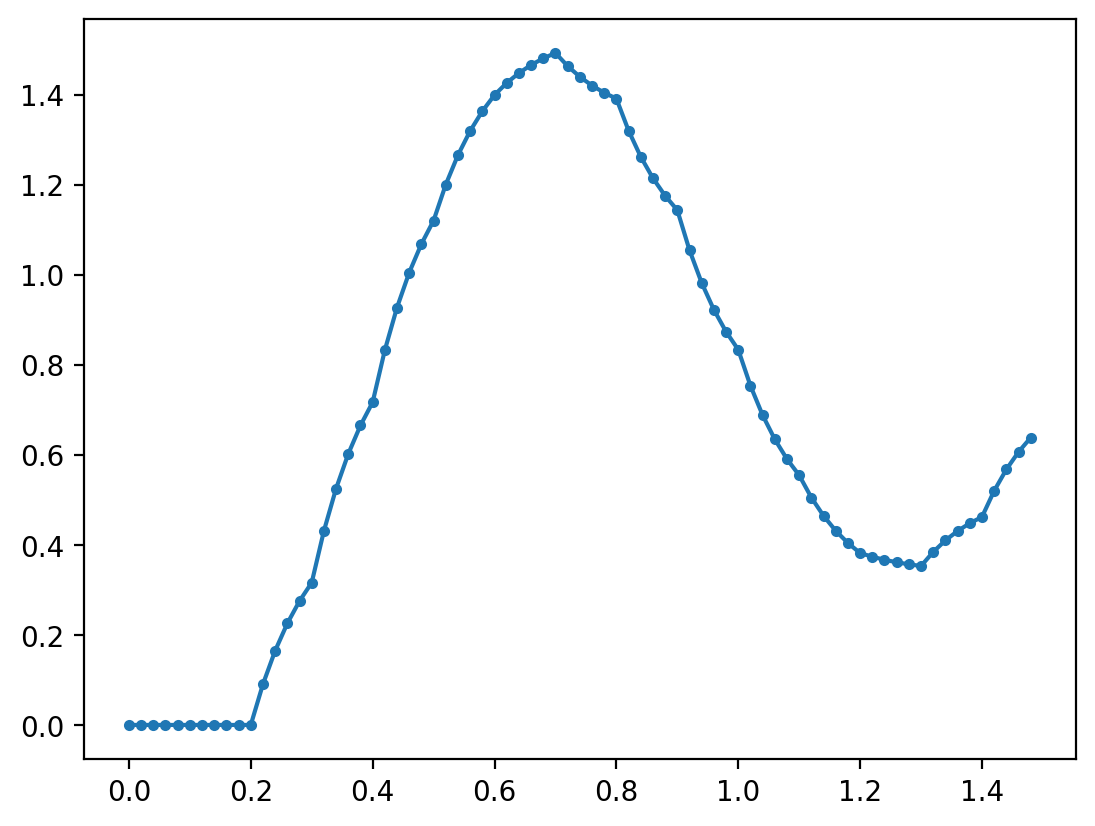

In [9]:
# incorporate delay into system by relabeling plant input signal
plant_simulator = ct.ss(plant_simulator, inputs='ud', outputs='y')

# system from r to y
Gyr_simulator = ct.interconnect([controller_simulator, plant_simulator, u_summer, delayer], 
                                inputs='r', outputs='y')

# simulate
t, y = ct.input_output_response(Gyr_simulator, time, step_input)
plt.plot(t, y, '.-');

We can also observe how the dynamics behave with a nonlinear plant.

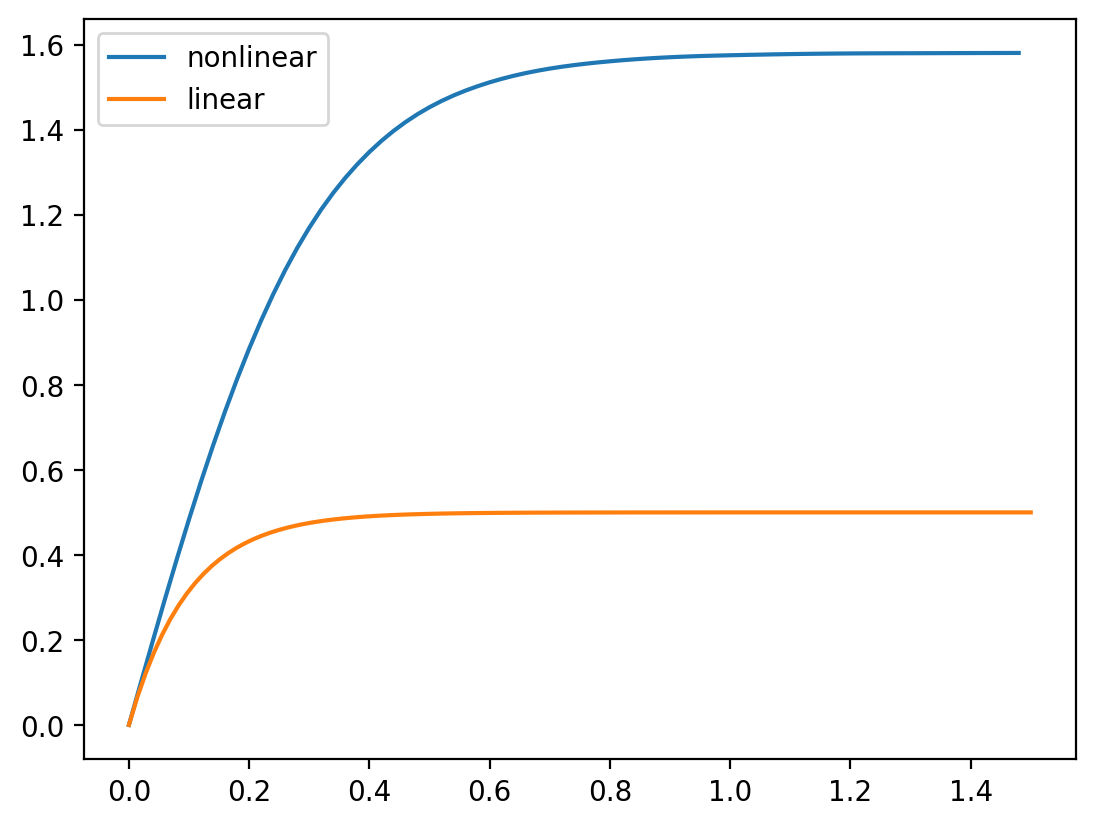

In [10]:
def nonlinear_plant_dynamics(t, x, u, params):
    return -10 * x * abs(x) +  u
def nonlinear_plant_output(t, x, u, params):
    return 5 * x
nonlinear_plant = ct.ss(nonlinear_plant_dynamics, nonlinear_plant_output, 
                        inputs='ud', outputs='y', states=1)

# compare step responses 
t, y = ct.input_output_response(nonlinear_plant, time, step_input)
plt.plot(t, y, label='nonlinear')
t, y = ct.step_response(plantcont, 1.5)
plt.plot(t, y, label='linear')
plt.legend();

## now create a closed-loop system. 

Note that this system is not intended to show operation of well-designed feedback control system. 

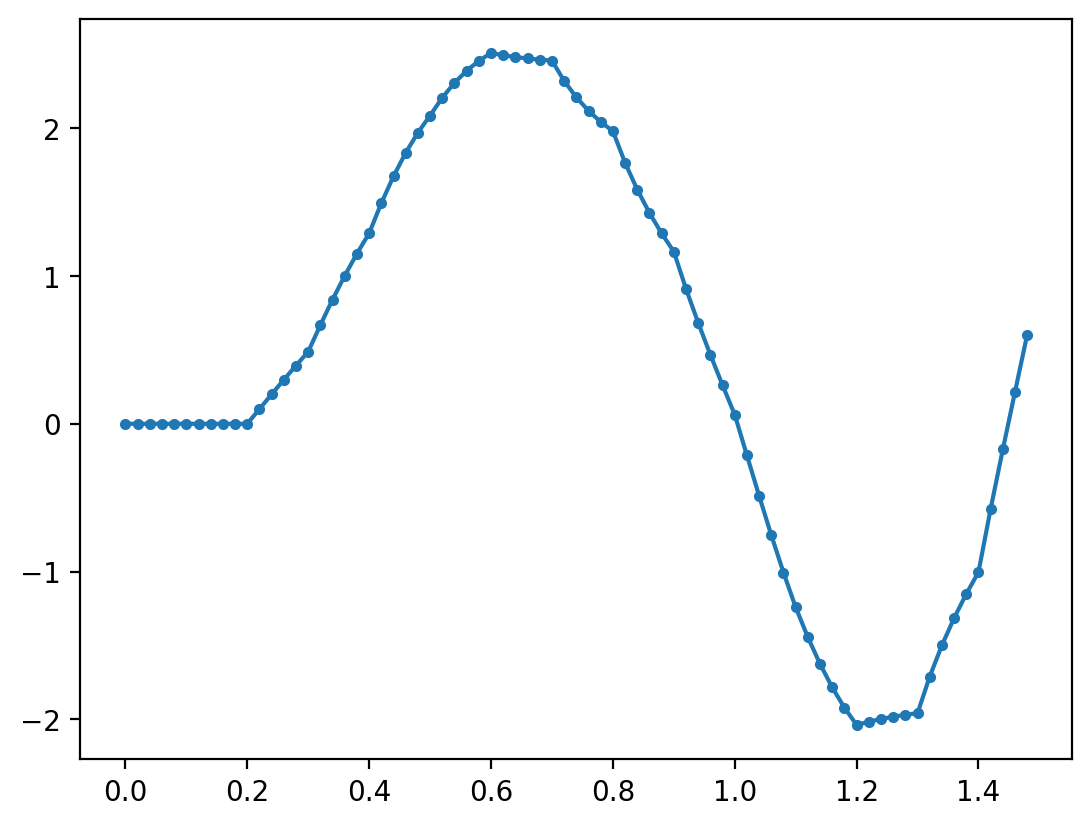

In [11]:
# create zero-order hold approximation of plant2 dynamics
def discrete_nonlinear_plant_dynamics(t, x, u, params):
    return x + simulation_dt * nonlinear_plant_dynamics(t, x, u, params)
nonlinear_plant_simulator = ct.ss(discrete_nonlinear_plant_dynamics, nonlinear_plant_output, 
                                  dt=simulation_dt,
                                  inputs='ud', outputs='y', states=1)

# system from r to y
nonlinear_Gyr_simulator = ct.interconnect([controller_simulator, nonlinear_plant_simulator, u_summer, delayer], 
                                inputs='r', outputs=['y', 'u'])

# simulate
t, y = ct.input_output_response(nonlinear_Gyr_simulator, time, step_input)
plt.plot(t, y[0],'.-');